# Getting Started with Error Mitigation with mitiq on Braket 

The presence of errors in quantum computing ultimately hinders their application as well. The simplest model, i.e. local or globabl depolarizing noise, represents how noise generally removes information from a quantum system. Error mitigation attempts to, similar to improving a signal-to-noise ratio, generally at the cost of repeated measurements. 

mitiq is an open source Python toolkit for implementing error mitigation techniques, which covers a breadth of different methodoloies and tools. 

In these notebooks, we show to utilize mitiq with Amazon Braket, specifically focusing on utilizing Program Sets to orchestrate our job submissions. 

Resolve Imports 

In [ ]:
import os
import sys

# from mitiq_tools import get_emulator
from mitiq import MeasurementResult
from mitiq.rem import post_select, execute_with_rem, mitigate_executor, mitigate_measurements, rem_decorator
from mitiq.rem.inverse_confusion_matrix import sample_probability_vector, generate_inverse_confusion_matrix, generate_tensored_inverse_confusion_matrix
from braket.circuits.observables import I, Z
from braket.circuits import Circuit
from braket.devices import LocalSimulator
from noise_models import qd_depol, qd_readout
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="qiskit_braket_provider")
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir))) # parent directory 
# qd = get_emulator() # here we can specify any device to return the noisy emulator 
from qiskit import transpile, QuantumCircuit
from qiskit_braket_provider import to_braket, to_qiskit
from qiskit_braket_provider.providers.adapter import aws_device_to_target
import numpy as np 
from tools import run_with_program_sets

from braket.emulation.local_emulator import LocalEmulator
import json

with open("emerald_properties_251106.json","r") as fp:
    props = json.load(fp)

emulator = LocalEmulator.from_json(props)
qd = LocalSimulator("braket_dm",noise_model= emulator._noise_model)

# target = aws_device_to_target(qd)

## Readout Error Mitigation

Readout errors occur due to challenges in using device measurement. Because for static circuits (i.e. the tradiational circuit model), we only need to measure once, readout errors are commonly used. 

In [2]:
# let's get a 6-qubit local readout 

results = []
shots = []

for i in range(2**6):
    circ = Circuit()
    bstr = f"{i:06b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)

    circ = to_braket(to_qiskit(circ, add_measurements=False), 
                     basis_gates = ["r", "cz","barrier", "measure"])
    results.append(qd.run(circ.measure(range(6)),shots=10000).result().measurement_probabilities)

print(circ)



T  : │         0         │  1  │
      ┌─────────────────┐ ┌───┐ 
q0 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q1 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q2 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q3 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q4 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
      ┌─────────────────┐ ┌───┐ 
q5 : ─┤ PRx(3.14, 0.00) ├─┤ M ├─
      └─────────────────┘ └───┘ 
T  : │         0         │  1  │


In [3]:
cm = np.zeros((2**6,2**6))
np.set_printoptions(precision=3,linewidth=400,suppress=True)

for n,meas_results in enumerate(results):
    for k,v in meas_results.items():
        cm[n , int(k,2)] = v

for i in range(64):
    print(cm[:,i])

[0.818 0.061 0.018 0.002 0.016 0.001 0.    0.    0.054 0.003 0.002 0.    0.001 0.    0.    0.    0.014 0.001 0.    0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.065 0.821 0.002 0.017 0.002 0.015 0.    0.    0.004 0.057 0.    0.002 0.    0.001 0.    0.    0.001 0.016 0.    0.001 0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.018 0.002 0.803 0.067 0.001 0.    0.016 0.001 0.003 0.    0.052 0.004 0.    0.    0.001 0.    0.    0.    0.015 0.001 0.    0.    0.001 0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

In [4]:
test = generate_tensored_inverse_confusion_matrix(6, confusion_matrices=[cm])
print(test)




[[ 1.236 -0.098 -0.027 ...  0.     0.     0.   ]
 [-0.092  1.233  0.002 ...  0.     0.     0.   ]
 [-0.028  0.001  1.261 ...  0.     0.     0.   ]
 ...
 [ 0.     0.     0.    ...  1.232  0.002 -0.03 ]
 [ 0.     0.     0.    ...  0.001  1.238 -0.1  ]
 [ 0.     0.     0.    ... -0.029 -0.102  1.239]]


In [5]:
circ = Circuit().h(0).cnot(0,1).cnot(1,2).cnot(2,3).cnot(3,4).cnot(4,5).measure(range(6))
circ = to_braket(to_qiskit(circ, add_measurements=False), 
                    basis_gates = ["r", "cz","barrier", "measure"])
# 

raw_results = []

@rem_decorator(inverse_confusion_matrix=test)
def GHZ_res(circ):
    counts = qd.run(circ, shots = 10000).result().measurement_counts
    raw_results.append(counts)
    return MeasurementResult.from_counts(counts)

res = GHZ_res(circ).get_counts()
print(res)
print(raw_results)



{'000000': 4930, '111111': 4848, '111100': 16, '111110': 58, '000001': 49, '011111': 13, '010000': 22, '110100': 1, '111000': 10, '101011': 3, '111101': 8, '100000': 13, '000100': 2, '000011': 4, '001001': 1, '110000': 9, '000111': 5, '001000': 1, '110110': 2, '101101': 1, '001111': 2, '110111': 1, '011110': 1}
[Counter({'000000': 4029, '111111': 3978, '111110': 371, '000001': 339, '001000': 268, '110111': 248, '111101': 107, '000010': 90, '010000': 90, '000100': 84, '101111': 81, '111011': 78, '110110': 24, '001001': 20, '111100': 19, '100000': 15, '111000': 13, '110000': 13, '011111': 13, '000011': 12, '000111': 10, '011000': 7, '101110': 7, '010001': 7, '110101': 7, '001010': 7, '000101': 6, '100111': 5, '110011': 5, '101011': 5, '001100': 5, '100001': 5, '000110': 4, '001111': 4, '101101': 4, '111010': 3, '011110': 2, '110100': 2, '010100': 2, '111001': 2, '110010': 1, '001110': 1, '101010': 1, '101000': 1, '100010': 1, '010011': 1, '010111': 1, '010010': 1, '011001': 1})]


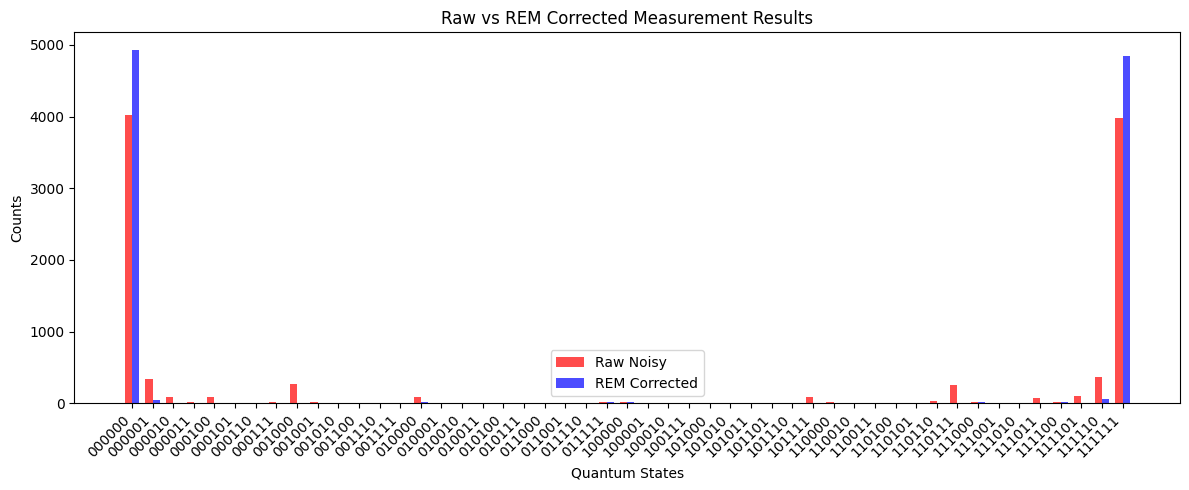

In [6]:
import matplotlib.pyplot as plt

raw_counts = raw_results[0]
corrected_counts = res

all_states = sorted(set(raw_counts.keys()) | set(corrected_counts.keys()))
raw_values = [raw_counts.get(state, 0) for state in all_states]
corr_values = [corrected_counts.get(state, 0) for state in all_states]


plt.figure(figsize=(12,5))
x = range(len(all_states))
width = 0.35
plt.bar([i - width/2 for i in x], raw_values, width, label='Raw Noisy', color='red', alpha=0.7)
plt.bar([i + width/2 for i in x], corr_values, width, label='REM Corrected', color='blue', alpha=0.7)
plt.xlabel('Quantum States')
plt.ylabel('Counts')
plt.title('Raw vs REM Corrected Measurement Results')
plt.xticks(x, all_states, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

With program sets, we can streamline this execution. Namely, we have that:


In [7]:
# let's get a 6-qubit local readout 
from braket.program_sets import ProgramSet

circuits = []
for i in range(2**6):
    circ = Circuit()
    bstr = f"{i:06b}"

    for n,b in enumerate(bstr):
        circ.x(n) if b=="1" else circ.i(n)

    circ = to_braket(to_qiskit(circ, add_measurements=False), 
                     basis_gates = ["r", "cz","barrier", "measure"],qubit_labels=[1,2,6,12,11,5])
    circuits.append(circ.measure(range(6)))

pset = ProgramSet(circuits, shots_per_executable=10000)

result = qd.run(pset).result()
 


/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/default_simulator/simulator.py:333: UserWarning: You are running a noise-free circuit on the density matrix simulator. Consider running this circuit on the state vector simulator: LocalSimulator("default") for a better user experience.
  warnings.warn(


This can be performed in a single submission, reducing queue times and total cost \$0.32 * (64-1) ~ \$19, just from job submission. 

### Readout Error Mitigation with Twirling 

We can simplify the above procedure somewhat by considering a variant of the readout procedure. Instead of measuring all inputs states and all output states, if we were to r


The measurement POVM in the computational basis can be inerepreted as $M_i = \frac{1}{2}(I_i \pm Z_i)$. The measurement channel itself has the form $\mathcal{E}[\rho] = M_0 \rho M_0 + M_1 \rho M_1$. Drawing from a future example, we can effectively twirl the circuit by inserting Pauli gates before and after. For a measurment channel, this will yield an effective bitflip channel, which is symmetric. 

The main difference however is the cost of learning - in a single configuration we can learn all the transition coeffieints to precision $1/\sqrt{N}$. Another way to think of this is that most states have similar transition rates from 0 to 1 and 1 to 0. If we randomly flip these for all states, then we effectively average it out so that the former statement is true on average. 

In practice, let's allocate 10000 shots, to learn probabilities to a precision of naively 0.01. We will visualize the resulting distribution for 1, 10, 100, and 1000 twirls. 

In [8]:
from tools.mitigation_tools import apply_readout_twirl
from noise_models import qd_readout_2


circuit = Circuit().z(0).z(1).z(2).z(3)

variants, bit_masks = apply_readout_twirl(circuit, num_samples = 5)

for v in variants:
    print(v)
print(bit_masks)


T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ X ├─┤ Z ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ Z ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ H ├─┤ X ├─
      └───┘ └───┘ 
T  : │  0  │  1  │
T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ X ├─┤ Y ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ X ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ H ├─┤ X ├─
      └───┘ └───┘ 
T  : │  0  │  1  │
T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ X ├─┤ I ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ Z ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ H ├─┤ I ├─
      └───┘ └───┘ 
T  : │  0  │  1  │
T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ X ├─┤ I ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ I ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ H ├─┤ Z ├─
      └───┘ └───┘ 
T  : │  0  │  1  │
T  : │  0  │  1  │
      ┌───┐ ┌───┐ 
q0 : ─┤ X ├─┤ Z ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q1 : ─┤ H ├─┤ Y ├─
      └───┘ └───┘ 
      ┌───┐ ┌───┐ 
q3 : ─┤ H ├─

Now, let's see how performing twirls can standardize our distribution.  

In [43]:
n_twirls = [1,10,100,1000,10000]
device = qd_readout_2

circuit = Circuit()
for i in range(6):
    circuit.z(i)


distributions = []
for n in n_twirls:
    variants, masks  = apply_readout_twirl(circuit, n)
    variants = [device._noise_model.apply(v.measure(range(6))) for v in variants]

    pset = ProgramSet(variants, shots_per_executable= 1000000//n)
    results = device.run(pset).result()

    base = {}
    for item, mask in zip(results, masks):
        for k, v in item.entries[0].probabilities.items():
            kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
            base[kp] = base.get(kp, 0) + v

    # Normalize
    base = {k: v/n for k, v in base.items()}

    distributions.append(base)
    print(base)



/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 0.598072, '000100': 0.021497, '100000': 0.099919, '000001': 0.061261, '101000': 0.011378, '001000': 0.067737, '010010': 0.002257, '010000': 0.042858, '100001': 0.010382, '000010': 0.030052, '010001': 0.004364, '100100': 0.003629, '100010': 0.005024, '110000': 0.007287, '001001': 0.007007, '000101': 0.002245, '000110': 0.001192, '011000': 0.004979, '110010': 0.000363, '101001': 0.001147, '001100': 0.00254, '100101': 0.000408, '001011': 0.000377, '000011': 0.003052, '001010': 0.003448, '010100': 0.001625, '101100': 0.000428, '110011': 3.3e-05, '001110': 0.000144, '110001': 0.000739, '101010': 0.000559, '011100': 0.000175, '111000': 0.000818, '001101': 0.000268, '010011': 0.000228, '010110': 7.5e-05, '100011': 0.000522, '100110': 0.000184, '110100': 0.000268, '010101': 0.000182, '011001': 0.0005, '111100': 4e-05, '011010': 0.000236, '111001': 8.3e-05, '101011': 6.1e-05, '011110': 9e-06, '110110': 1.1e-05, '101101': 4.8e-05, '110101': 2.3e-05, '111010': 4e-05, '000111': 0.000116

In particular, we will plot the distribution of errors from the mean (assuming the 10000 twirls result as the population mean). 

/var/folders/1_/bfh8x9qn75164y0b808mvhrh0000gq/T/ipykernel_16502/3854673659.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


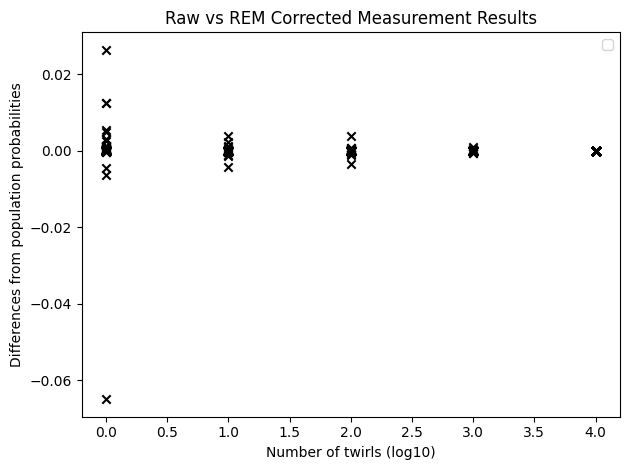

In [49]:
import matplotlib.pyplot as plt

raw_counts = raw_results[0]
corrected_counts = res

bars = [f"{k:06b}" for k in range(2**6)]

data = np.array([[distributions[i].get(state, 0) for state in bars] for i in range(len(distributions))])
data = data - data[-1,:] # broadcast the final entries 
data = data[:,:]
plt.figure()
# for i in range(len(distributions)-1):
for i in range(len(bars)):
    plt.scatter(range(len(distributions)), data[:,i], c= 'k', marker ='x')
    # plt.hist(data[i,:], bins = 50)
plt.xlabel('Number of twirls (log10)')
plt.ylabel('Differences from population probabilities')
plt.title('Raw vs REM Corrected Measurement Results')
plt.legend()
plt.tight_layout()
plt.show()

In [64]:
for i,n in enumerate(n_twirls[:-1]):    
    errors = data[:,i]
    print(f"errors (from largest result) across 10^{int(np.log10(n))} twirl(s): {np.average(errors):+.3f} +/- {np.std(errors):.3f}")

errors (from largest result) across 10^0 twirl(s): -0.013 +/- 0.026
errors (from largest result) across 10^1 twirl(s): +0.001 +/- 0.006
errors (from largest result) across 10^2 twirl(s): -0.001 +/- 0.002
errors (from largest result) across 10^3 twirl(s): +0.000 +/- 0.000


This distribution will look different for various noise models and realistic devices (in particular, symmetric noise would be a constant). Here we can see that the amplitude damping noise, which biases the measurement result towards a particular state, is effectively mitigated. 

When considering the precision, we see that even 10 twirls well approximates the mean, and at 100 twirls our standard deviations is nearly at our expected sampling threshold of 0.001. 


### Applying Twirls Results


Let's take the 100 twirled result as our baseline. 



In [66]:
device = qd_readout_2

total_shots = 10000
total_twirls = 100

circuit = Circuit()
for i in range(6):
    circuit.z(i)

distributions = []
variants, masks  = apply_readout_twirl(circuit, total_twirls)
variants = [device._noise_model.apply(v.measure(range(6))) for v in variants]

pset = ProgramSet(variants, shots_per_executable= total_shots//total_twirls)
results = device.run(pset).result()

base = {}
for item, mask in zip(results, masks):
    for k, v in item.entries[0].probabilities.items():
        kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
        base[kp] = base.get(kp, 0) + v

# Normalize
base = {k: v/total_twirls for k, v in base.items()}

distributions.append(base)
print(base)



/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)


{'000000': 0.6625999999999997, '001000': 0.054199999999999963, '010010': 0.0022000000000000006, '100000': 0.07419999999999999, '000001': 0.045399999999999954, '101100': 0.0004, '010000': 0.04399999999999997, '000010': 0.03439999999999998, '011000': 0.004500000000000001, '001010': 0.0031000000000000003, '001001': 0.004100000000000002, '101000': 0.005500000000000002, '101001': 0.0005, '000100': 0.029399999999999985, '001100': 0.0020000000000000005, '100010': 0.0049000000000000024, '110000': 0.005000000000000004, '100110': 0.0003, '100001': 0.005800000000000003, '101010': 0.0003, '110100': 0.0002, '010001': 0.002800000000000001, '111000': 0.0007000000000000001, '000011': 0.0029000000000000015, '010011': 0.0002, '100100': 0.0029000000000000002, '010100': 0.0017000000000000001, '000110': 0.0019000000000000002, '011001': 0.0002, '000101': 0.0018000000000000002, '100011': 0.0004, '101011': 0.0001, '011100': 0.0002, '010101': 0.0001, '001101': 0.0002, '110110': 0.0001, '011010': 0.0001, '00101

In [77]:
from functools import reduce 

qubit_tallies = [0,0,0,0,0,0]
for i in range(6):
    for k,v in base.items():
        if k[i] == '1':
            qubit_tallies[i] += v

confusion_matrix = np.array([])

print(qubit_tallies)
mats = [generate_inverse_confusion_matrix(1,p0=i,p1=i) for i in qubit_tallies]
print(mats[0])
mat = reduce(np.kron, mats, np.array([[1]]))
print(mat)



[0.10180000000000002, 0.06239999999999999, 0.0762, 0.041499999999999995, 0.05129999999999999, 0.06489999999999999]
[[ 1.128 -0.128]
 [-0.128  1.128]]
[[ 1.564 -0.109 -0.085 ... -0.    -0.     0.   ]
 [-0.109  1.564  0.006 ...  0.     0.    -0.   ]
 [-0.085  0.006  1.564 ...  0.     0.    -0.   ]
 ...
 [-0.     0.     0.    ...  1.564  0.006 -0.085]
 [-0.     0.     0.    ...  0.006  1.564 -0.109]
 [ 0.    -0.    -0.    ... -0.085 -0.109  1.564]]


### On the Variance of Measurement Inversion

From [this reference](https://arxiv.org/pdf/2006.14044), we can see that the variance for a tensor product is naively:

$$ \gamma =  \prod_{j=1}^n \frac{1}{1 - 2 p_j}$$

where $p_j$ is the effective bitflip error rate.


In [75]:
from itertools import product 
gamma = reduce(lambda x,y: x*y,[1/ (1- 2*pi) for pi in qubit_tallies], 1)

print(f"gamma factor: {gamma}")

gamma factor: 2.363719901535741


Let's try to confirm this. Using the 6-qubit result, we can prepare a Hadamard state, and then plot the variances as a function of sample size. 

A more scalable approach may involve taking the tensor products, and applying them entry wise to output bitstring results. 




In [ ]:

def apply_rem(circuit : Circuit, shots = 10000):
    variants, masks  = apply_readout_twirl(circuit, 100)
    variants = [device._noise_model.apply(v.measure(range(6))) for v in variants]

    pset = ProgramSet(variants, shots_per_executable= shots//100)
    results = device.run(pset).result()
 
    dist = {}
    for item, mask in zip(results, masks):
        for k, v in item.entries[0].counts.items():
            kp = ''.join(str(int(a) ^ int(b)) for a, b in zip(k, mask))
            dist[kp] = dist.get(kp, 0) + v
    return MeasurementResult.from_counts(dist)


 


In [112]:
def mean_errors(shots):
    errors = []
    for i in range(100):
        circ = Circuit()
        bits = ["0"]*6
        for j in range(6):
            if np.random.random() > 0.5:
                circ.x(j) 
                bits[j] = "1"
            else:
                circ.z(j)
        test = mitigate_measurements(apply_rem(circ, shots = shots), inverse_confusion_matrix=mat) 
        # print(test.to_dict())
        errors.append(1-test.prob_distribution().get("".join(bits),0))
    return errors

t0 = mean_errors(100)

/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise_model_to_circuit(task_specification)
/Users/sesmart/projects/04_em_mitiq/code/.venv/lib/python3.12/site-packages/braket/devices/local_simulator.py:127: UserWarning: Noise model is only applicable to circuits. The type of the task specification is ProgramSet. The noise model of the device does not apply.
  task_specification = self._apply_noise

(array([48., 17.,  9.,  6.,  4.,  5.,  2.,  5.,  2.,  2.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ]),
 <BarContainer object of 10 artists>)

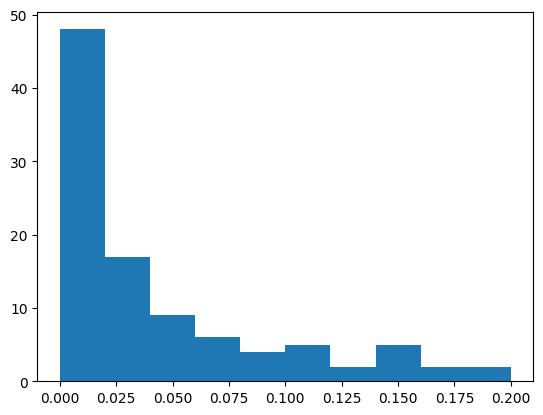

In [114]:
plt.hist(t0)

### References 

In [ ]:
https://arxiv.org/pdf/2006.14044